###**ATOC4500 Data Science Lab: Final Project**
###**Title of Your Project**
###Author: Ben Kizziar, beki4333@colorado.edu###
###last updated: March 21, 2022###

**>>>> This code is available on github at (insert URL)**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

###**Introduction:** Write your text here.  Include a hypothesis and underlying motivation.



My hypothesis is that the December El Nino 3.4 anomalies affect the total winter snow accumulation in Loveland, Colorado. I hope to learn about what the connection is between the sea surface temperature anomalies driven by ENSO and the snow water equivalent levels in Loveland, Colorado. I expect that during El Nino anomalies, the snowfall is larger than average and during La Nina anomalies the snowfall is less than average. 

**Citations**

Anon (n.d.), Nino SST indices (Nino 1+2, 3, 3.4, 4; Oni and TNI), Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI) | NCAR - Climate Data Guide. Available from: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni (Accessed 27 April 2022) 


Anon (n.d.), T table - san jose State University, Available from: https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf (Accessed 27 April 2022) 


Barnes (n.d.), BARNES_ch1_basic_statistics.pdf 


Zach (2020), How to perform Welch's T-test in python, Statology. Available from: https://www.statology.org/welch-t-test-python/ (Accessed 27 April 2022) 

###**Step 1: Read in data**



The dataset I am using is the snow_enso_data.csv. The variables I have in my data are the El Nino 3.4 anomaly values and the snow water equivalence measurements from Loveland Pass, Colorado. The data covers the time period from 1936 to 2016. The timestep is yearly. The size of my data is 1274 bytes. The data has been munged as the variables of the anomaly and snow water equivalence have been put on the same dataset and measured in the same timstep. There has also been quality control on the data as it was pre evaluated by the professor. There is no missing data in this dataset.
The El Nino 3.4 anomaly refers to the measure of the sea surface temperature (SST) anomaly in December which is driven by El Nino Southern Oscillation (degrees celsius). The snow water equivalence (SWE) is a measure of the amount of water in a snowpack (inches). This value is measured in Loveland Pass, Colorado the following April. El Nino conditions are said to be occurring when the anomaly is 0.4 degrees celsius or more above the average and La Nina conditions are said to be occurring when the anomaly is 0.4 degrees celsius or more under the average. The higher the anomaly value, the stronger the conditions of the respective event are. 


In [183]:
## add code cells here to read in your data

In [184]:
### import packages
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import relativedelta
import csv
from scipy import stats
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
from google.colab import files

In [185]:
# function to standardize data, we'll steal this function from a previous notebook used in this class.
# recall that standardize the data = remove the mean, divide by the standard deviation.  
def standardize(raw_data):
    sample_mean = np.mean(raw_data)
    sample_std = np.std(raw_data)
    standardized_list = []
    for i in raw_data:
        standardized_list.append((i - sample_mean)/sample_std)
    return standardized_list

In [186]:
### upload file snow_enso_data.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving snow_enso_data.csv to snow_enso_data (4).csv
User uploaded file "snow_enso_data.csv" with length 1274 bytes


In [187]:
## Read in the data
data = pd.read_csv("snow_enso_data.csv")

In [188]:
# Look at your data by printing it
# preview data (also through data.head() & data.tail())
print(data.head())
print(data.tail())

year=data['Year']
#print(day.head())
#print(day.tail())
data

   Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
0  1936                           15.8                   -0.04
1  1937                           10.1                    0.63
2  1938                           12.1                    0.22
3  1939                           18.2                   -0.79
4  1940                           10.0                    0.05
    Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
76  2012                           12.8                   -1.05
77  2013                           14.9                   -0.13
78  2014                           24.4                   -0.09
79  2015                           16.4                    0.77
80  2016                           19.0                    2.56


,Year,LovelandPass_April1SWE_inches,Nino34_anomaly_prevDec
0,1936,15.8,-0.04
1,1937,10.1,0.63
2,1938,12.1,0.22
3,1939,18.2,-0.79
4,1940,10.0,0.05
...,...,...,...
76,2012,12.8,-1.05
77,2013,14.9,-0.13
78,2014,24.4,-0.09
79,2015,16.4,0.77


In [189]:
April_SWE=data['LovelandPass_April1SWE_inches']
Nino34_anom=data['Nino34_anomaly_prevDec']

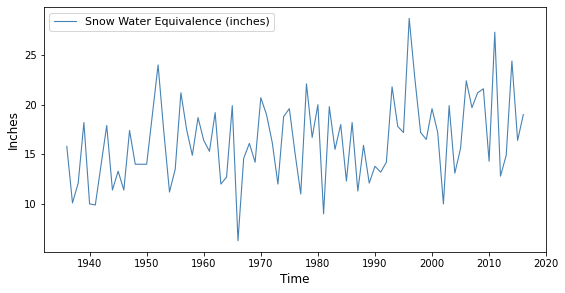

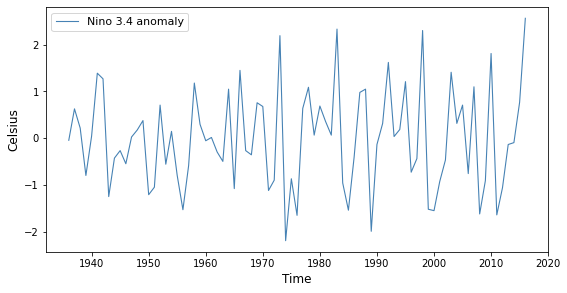

In [217]:
fig = plt.figure(figsize=(9,4.5));
plt.plot(year, April_SWE, color='steelblue', lw=1.1,label='Snow Water Equivalence (inches)');
plt.xlabel("Time",fontsize=12);
plt.ylabel("Inches",fontsize=12);
plt.legend(loc='upper left',fontsize=11);
plt.show()

fig = plt.figure(figsize=(9,4.5));
plt.plot(year, Nino34_anom, color='steelblue', lw=1.1,label='Nino 3.4 anomaly');
plt.xlabel("Time",fontsize=12);
plt.ylabel("Celsius",fontsize=12);
plt.legend(loc='upper left',fontsize=11);
plt.show()

###**Step 2: Munge data**

include description of all data processing steps here

In [191]:
elninoyrs = data.loc[data['Nino34_anomaly_prevDec'] > 1]
print(elninoyrs)

April_SWE_elnino=elninoyrs['LovelandPass_April1SWE_inches']

N1=len(elninoyrs)
sigma1=np.std(April_SWE_elnino)  ## calculate the standard deviation
mean=np.mean(April_SWE_elnino)  ## calculate the mean
print('Sample Size N=',N1)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma1,1))


    Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
5   1941                            9.9                    1.39
6   1942                           13.9                    1.27
22  1958                           14.9                    1.18
28  1964                           12.7                    1.05
30  1966                            6.3                    1.45
37  1973                           12.0                    2.19
42  1978                           22.1                    1.09
47  1983                           15.5                    2.33
52  1988                           15.9                    1.05
56  1992                           14.2                    1.62
59  1995                           17.2                    1.21
62  1998                           17.2                    2.30
67  2003                           19.9                    1.41
71  2007                           19.7                    1.10
74  2010                           14.3 

In [192]:
laninayrs = data.loc[data['Nino34_anomaly_prevDec'] < -1]
print(laninayrs)

April_SWE_lanina=laninayrs['LovelandPass_April1SWE_inches']

N2=len(laninayrs)
sigma2=np.std(April_SWE_lanina)  ## calculate the standard deviation
mean=np.mean(April_SWE_lanina)  ## calculate the mean
print('Sample Size N=',N2)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma2,1))

#Nino34_anomaly_prevDec = 


    Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
7   1943                           17.9                   -1.24
14  1950                           14.0                   -1.20
15  1951                           19.0                   -1.04
20  1956                           21.2                   -1.52
29  1965                           19.9                   -1.07
35  1971                           19.0                   -1.11
38  1974                           18.8                   -2.18
40  1976                           15.1                   -1.64
49  1985                           12.3                   -1.53
53  1989                           12.1                   -1.98
63  1999                           16.5                   -1.51
64  2000                           19.6                   -1.54
72  2008                           21.2                   -1.61
75  2011                           27.3                   -1.63
76  2012                           12.8 

In [193]:
## add code cells here to process your data to prepare it for the data science method, i.e. "munge" it

In [194]:
var1= April_SWE   ### EDIT right-hand side of = statement to select var1
var2= Nino34_anom ### EDIT right-hand side of = statement to select var2

### calculate the mean and standard deviation of your data variables (var1, var2)
### print the values
N=len(data)
sigma=np.std(var1)  ## calculate the standard deviation
mean=np.mean(var1)  ## calculate the mean
print('Sample Size N=',N)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma,1))

N=len(data)
sigma=np.std(var2)  ## calculate the standard deviation
mean=np.mean(var2)  ## calculate the mean
print('Sample Size N=',N)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma,1))

Sample Size N= 81
Mean 16.3
Standard Deviation 4.2
Sample Size N= 81
Mean -0.0
Standard Deviation 1.1


In [195]:
## standardize the data (i.e., remove the mean, divide by the standard deviation)
var1_stand = standardize(var1)
var2_stand = standardize(var2)

## check that your data have a mean of 0 and a standard deviation of 1
print(f'mean var1: {np.round(np.mean(var1_stand),1)}')
print(f'mean var2: {np.round(np.mean(var2_stand),1)}')
print(f'std  var1: {np.round(np.std(var1_stand),1)}')
print(f'std  var2: {np.round(np.std(var2_stand),1)}')

mean var1: -0.0
mean var2: 0.0
std  var1: 1.0
std  var2: 1.0


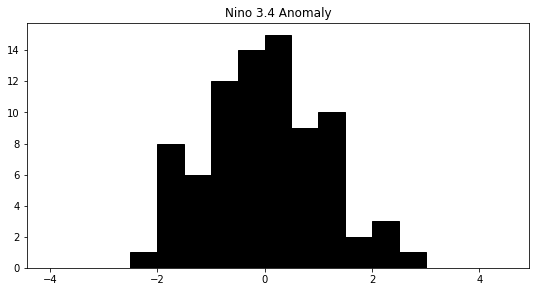

In [200]:
## Make a histogram plot of standardized values - var1
## define bins
delta=0.5                            ## bin size
minbin=-4                      ## minimum bin value
maxbin= 5                 ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
## plot histogram
fig = plt.figure(figsize=(9,4.5));
plt.hist(Nino34_anom,bins=hist_bins,facecolor='k',edgecolor="k");
plt.title('Nino 3.4 Anomaly');

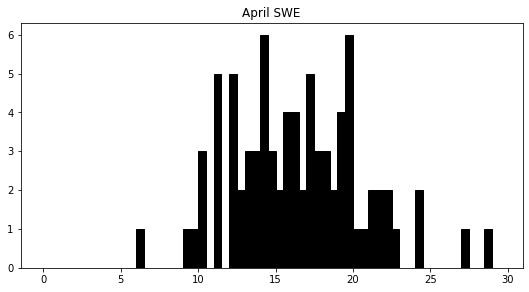

In [201]:
## Make a histogram plot of standardized values - var1
## define bins
delta=0.5                            ## bin size
minbin=0                       ## minimum bin value
maxbin=30                    ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
## plot histogram
fig = plt.figure(figsize=(9,4.5));
plt.hist(April_SWE,bins=hist_bins,facecolor='k',edgecolor="k");
plt.title('April SWE');

###**Step 3: Apply Data Science Method(s)**

include description of step 3 here, include assumptions

My application of data science methods will be running a 95% confidence interval T-test to determine whether or not there is a statistical different in snowpack levels in El Nino years vs La Nina years. This specific test comparing two means of two differnt data sets is called the Welch's T-test. 

I follow the 5-step hypothesis testing approach. 

In a Welch's T-test you have to find a t statistic using an equation given as well as a sigma value using another equation. These are shown below.

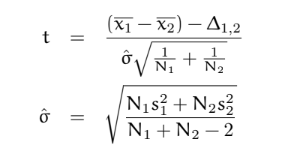

I first found the value of sigma and then using the results of that value, I used it to find the t-statistic. Then I compare the t-statistic to the critical t-value found using a 95% confidence interval and the degrees of freedom of N1 + N2 - 2 and from here claim the results of the hypothesis test. 

I test the sensitivity of the test by changing my definition of an El Nino/La Nina event from something being over 1 degree different than the average to over 0.5 degrees different than the average. 

At the end I have of each test I have code that dsiplays the t statistic and p-value a way to check my code. 



In [202]:
## add code cells here to apply your data science method



1.   **State the sigificance level:** 95%, alpha = 0.05
2.   **State the null hypothesis (H0):** El Nino years and La Nina years have different means.
   
3.   **State the statistic to be used, and the assumptions:** 
The Welch's T-Test
4.    **State the critical region:** 
Results will be consistent with the null hypothesis if the p-value is greater than 0.05 or t value is less than critcical t value of 2.045.
5.    **Evaluate the statistic and state the conclusion (provide code below)**

In [203]:
print(np.var(April_SWE_elnino), np.var(April_SWE_lanina))



#print(stats.ttest_ind(April_SWE_elnino, April_SWE_lanina, equal_var = False))

print(stats.ttest_ind(April_SWE_lanina, April_SWE_elnino, equal_var = False))


15.013085937499996 15.737600000000002
Ttest_indResult(statistic=1.7055587740514027, pvalue=0.09887219450337625)


In [204]:

def welch_ttest(elninodata,laninadata):
  N1 = len(elninodata)
  #print(N1)
  N2 = len(laninadata)
  #print(N2)
  sigma1 = np.std(elninodata)
  #print(sigma1)
  sigma2 = np.std(laninadata)
  #print(sigma2)
  SIGMA = np.sqrt((N1*sigma1**2 + N2*sigma2**2)/(N1 + N2 - 2))
  return SIGMA


In [205]:
sigmatest = welch_ttest(elninodata=elninoyrs['LovelandPass_April1SWE_inches'],laninadata=laninayrs['LovelandPass_April1SWE_inches'])
print(sigmatest)

4.052557196090661


In [206]:
def twelch_ttest(elninodata,laninadata):
  N1 = len(elninodata)
  N2 = len(laninadata)
  mean1 = np.mean(April_SWE_lanina)
  #print(mean1)
  mean2 = np.mean(April_SWE_elnino)
  #print(mean2)
  sigmatest = welch_ttest(elninodata=elninoyrs['LovelandPass_April1SWE_inches'],laninadata=laninayrs['LovelandPass_April1SWE_inches'])
  t = ((mean1 - mean2 - 0)/(sigmatest*(np.sqrt(N1**-1 + N2**-1))))
  return t


In [207]:
ttest = twelch_ttest(elninodata=elninoyrs['LovelandPass_April1SWE_inches'],laninadata=laninayrs['LovelandPass_April1SWE_inches'])
print(ttest)

1.707027104805739


In [208]:
print(np.var(April_SWE_elnino), np.var(April_SWE_lanina))



#print(stats.ttest_ind(April_SWE_elnino, April_SWE_lanina, equal_var = False))

print(stats.ttest_ind(April_SWE_lanina, April_SWE_elnino, equal_var = False))

15.013085937499996 15.737600000000002
Ttest_indResult(statistic=1.7055587740514027, pvalue=0.09887219450337625)


Critical t value for this test is 2.045, and the t value I found is 1.707. This is less than the critical t value so I reject the null hypothesis that the two means are different.

***Changing Sensitivity***

Now I will run the same hypothesis but change my definition of an anomaly to be greater than 0.5 degrees celsius for El Nino and less than -0.5 degreses celsius for La Nina.



1.   **State the sigificance level:** 95%, alpha = 0.05
2.   **State the null hypothesis (H0):** El Nino years and La Nina years have different means.
   
3.   **State the statistic to be used, and the assumptions:** 
The Welch's T-Test
4.    **State the critical region:** 
Results will be consistent with the null hypothesis if the p-value is greater than 0.05 or t value is less than critcical t value of 2.009.
5.    **Evaluate the statistic and state the conclusion (provide code below)**

In [209]:
elninoyrs2 = data.loc[data['Nino34_anomaly_prevDec'] >0.5]
print(elninoyrs2)

April_SWE_elnino2=elninoyrs2['LovelandPass_April1SWE_inches']

N1=len(elninoyrs2)
sigma1=np.std(April_SWE_elnino2)  ## calculate the standard deviation
mean=np.mean(April_SWE_elnino2)  ## calculate the mean
print('Sample Size N=',N1)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma1,1))

    Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
1   1937                           10.1                    0.63
5   1941                            9.9                    1.39
6   1942                           13.9                    1.27
16  1952                           24.0                    0.71
22  1958                           14.9                    1.18
28  1964                           12.7                    1.05
30  1966                            6.3                    1.45
33  1969                           14.2                    0.76
34  1970                           20.7                    0.68
37  1973                           12.0                    2.19
41  1977                           11.0                    0.64
42  1978                           22.1                    1.09
44  1980                           20.0                    0.69
47  1983                           15.5                    2.33
51  1987                           11.3 

In [210]:
laninayrs2 = data.loc[data['Nino34_anomaly_prevDec'] < -0.5]
print(laninayrs2)

April_SWE_lanina2=laninayrs2['LovelandPass_April1SWE_inches']

N2=len(laninayrs2)
sigma2=np.std(April_SWE_lanina2)  ## calculate the standard deviation
mean=np.mean(April_SWE_lanina2)  ## calculate the mean
print('Sample Size N=',N2)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma2,1))

    Year  LovelandPass_April1SWE_inches  Nino34_anomaly_prevDec
3   1939                           18.2                   -0.79
7   1943                           17.9                   -1.24
10  1946                           11.4                   -0.54
14  1950                           14.0                   -1.20
15  1951                           19.0                   -1.04
17  1953                           17.3                   -0.55
19  1955                           13.5                   -0.79
20  1956                           21.2                   -1.52
21  1957                           17.5                   -0.58
29  1965                           19.9                   -1.07
35  1971                           19.0                   -1.11
36  1972                           16.2                   -0.89
38  1974                           18.8                   -2.18
39  1975                           19.6                   -0.86
40  1976                           15.1 

In [211]:
var1= April_SWE   ### EDIT right-hand side of = statement to select var1
var2= Nino34_anom ### EDIT right-hand side of = statement to select var2

### calculate the mean and standard deviation of your data variables (var1, var2)
### print the values
N=len(data)
sigma=np.std(var1)  ## calculate the standard deviation
mean=np.mean(var1)  ## calculate the mean
print('Sample Size N=',N)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma,1))

N=len(data)
sigma=np.std(var2)  ## calculate the standard deviation
mean=np.mean(var2)  ## calculate the mean
print('Sample Size N=',N)
print('Mean',round(mean,1))
print('Standard Deviation',round(sigma,1))

Sample Size N= 81
Mean 16.3
Standard Deviation 4.2
Sample Size N= 81
Mean -0.0
Standard Deviation 1.1


In [212]:
def welch_ttest(elninodata2,laninadata2):
  N1 = len(elninodata2)
  #print(N1)
  N2 = len(laninadata2)
  #print(N2)
  sigma1 = np.std(elninodata2)
  #print(sigma1)
  sigma2 = np.std(laninadata2)
  #print(sigma2)
  SIGMA = np.sqrt((N1*sigma1**2 + N2*sigma2**2)/(N1 + N2 - 2))
  return SIGMA

In [213]:
sigmatest = welch_ttest(elninodata2=elninoyrs2['LovelandPass_April1SWE_inches'],laninadata2=laninayrs2['LovelandPass_April1SWE_inches'])
print(sigmatest)

4.205743867793363


In [214]:
def twelch_ttest(elninodata2,laninadata2):
  N1 = len(elninodata2)
  N2 = len(laninadata2)
  mean1 = np.mean(April_SWE_lanina2)
  #print(mean1)
  mean2 = np.mean(April_SWE_elnino2)
  #print(mean2)
  sigmatest = welch_ttest(elninodata2=elninoyrs2['LovelandPass_April1SWE_inches'],laninadata2=laninayrs2['LovelandPass_April1SWE_inches'])
  t = ((mean1 - mean2 - 0)/(sigmatest*(np.sqrt(N1**-1 + N2**-1))))
  return t

In [215]:
ttest = twelch_ttest(elninodata2=elninoyrs2['LovelandPass_April1SWE_inches'],laninadata2=laninayrs2['LovelandPass_April1SWE_inches'])
print(ttest)

2.1974860019152858


In [216]:
print(np.var(April_SWE_elnino2), np.var(April_SWE_lanina2))



#print(stats.ttest_ind(April_SWE_elnino, April_SWE_lanina, equal_var = False))

print(stats.ttest_ind(April_SWE_lanina2, April_SWE_elnino2, equal_var = False))

17.1992 16.830891632373113
Ttest_indResult(statistic=2.1964203917686005, pvalue=0.0327658715845448)


The critical t value for this 2.009. The t value I found was 2.197. This is greater than the critical t value so I fail to reject the null hypothesis that the two means are different. 

###**Step 4: Present results visually using 2-3 graphs**

In [237]:
## add code cells here to plot the results here

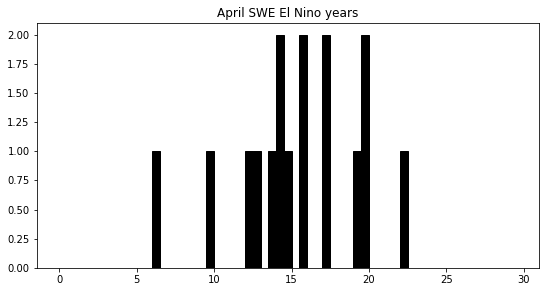

In [235]:
April_SWE_elnino=elninoyrs['LovelandPass_April1SWE_inches']


## define bins
delta=0.5                            ## bin size
minbin=0                       ## minimum bin value
maxbin=30                    ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
## plot histogram
fig = plt.figure(figsize=(9,4.5));
plt.hist(April_SWE_elnino,bins=hist_bins,facecolor='k',edgecolor="k");
plt.title('April SWE El Nino years');

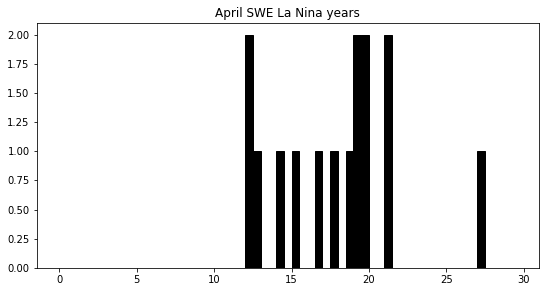

In [236]:
April_SWE_lanina=laninayrs['LovelandPass_April1SWE_inches']


## define bins
delta=0.5                            ## bin size
minbin=0                       ## minimum bin value
maxbin=30                    ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
## plot histogram
fig = plt.figure(figsize=(9,4.5));
plt.hist(April_SWE_lanina,bins=hist_bins,facecolor='k',edgecolor="k");
plt.title('April SWE La Nina years');

###**Summary**: Write your text here. Discuss what you found including how it relates to your hypothesis and underlying motivation.

From my project using a definition of a change in at least 1 degree celsius from the mean I was not able to find any statistical difference in snowmelt levels between El Nino years and La Nina years. This means that using ENSO events to predict snowpack levels would not work. However changing my defintion to a change in just 0.5 degrees celsius there was a statistical difference in the means showing that one could use ENSO events to determine snowpack levels. |